In [1]:
import torch
from simpegtorch.discretize import TensorMesh
from simpegtorch.simulation.resistivity import (
    DC2DCellCentered,
    SrcDipole,
    SrcPole,
    RxDipole,
    Survey,
)
from simpegtorch.simulation.base import DirectSolver, mappings
from simpegtorch.discretize.utils import ndgrid

# Import original simpeg for comparison
from simpeg.electromagnetics import resistivity as dc
from simpeg import maps
torch.set_default_dtype(torch.float64)

In [2]:
npad = 5
cs = 12.5
hx = [(cs, npad, -1.3), (cs, 30), (cs, npad, 1.3)]
hy = [(cs, npad, -1.3), (cs, 15)]
mesh = TensorMesh([hx, hy], origin="CN")
mesh

TensorMesh: 741 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     39       -311.24        311.24     12.50     46.41    2.86
   y     19       -288.04         -0.00     12.50     35.70    2.86

In [3]:
# Uniform halfspace conductivity
sigma_halfspace = 1e-3
sigma = torch.ones(mesh.nC) * sigma_halfspace

sigma_conductive = 1e2
# Add a conductive block
ind_block = (
    (mesh.gridCC[:, 0] > -0)
    & (mesh.gridCC[:, 0] < 50)
    & (mesh.gridCC[:, 1] > -100)
    & (mesh.gridCC[:, 1] < -10)
)

sigma[ind_block] = sigma_conductive
sigma_map = mappings.BaseMapping(sigma)



(-150.0, 150.0)

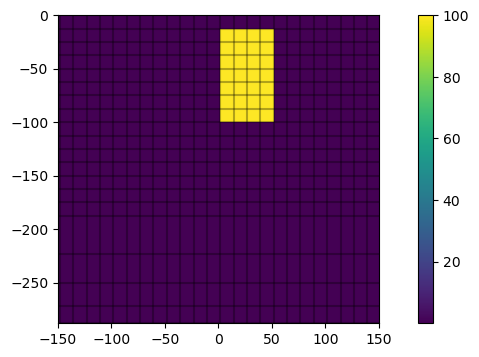

In [4]:
## Plot the survey geometry
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 4))
mesh.plot_grid(ax=ax, alpha=0.3)
mesh.plot_image(
    sigma_map.forward(),
    ax=ax,
    pcolor_opts={"cmap": "viridis"},
)
ax.set_xlim(-150, 150)

In [5]:
# Create a simple dipole-dipole survey based on actual mesh extent
# Get the cell centers that are within a reasonable range
x_min = float(mesh.cell_centers_x.min())
x_max = float(mesh.cell_centers_x.max())
x_range = x_max - x_min
# Use central 60% of mesh
x_center = (x_min + x_max) / 2
x_extent = x_range * 0.3

x = mesh.cell_centers_x[
    (mesh.cell_centers_x > x_center - x_extent) &
    (mesh.cell_centers_x < x_center + x_extent)
]
M = ndgrid(x, [0.0])
N = ndgrid(x + 25.0, [0.0])

rx = RxDipole(
    locations_m=M,
    locations_n=N,
)

loc_a = torch.tensor([-50.0, 0.0])
loc_b = torch.tensor([50.0, 0.0])

src = SrcDipole([rx], loc_a, loc_b, current=1.0)
survey_torch = Survey([src])


In [6]:
pde = DC2DCellCentered(
    mesh,
    survey_torch,
    sigma_map,
    nky=11
)
solver =  DirectSolver(pde)

/Users/tsuchijo/Documents/GIF_Work/simpeg-torch/simpegtorch/discretize/operators/differential_operators.py:308: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /Users/runner/miniforge3/conda-bld/libtorch_1746257065223/work/aten/src/ATen/SparseCsrTensorImpl.cpp:55.)
  sdiag(1 / V, device=self.device, dtype=self.dtype)


In [7]:
data = solver.forward()

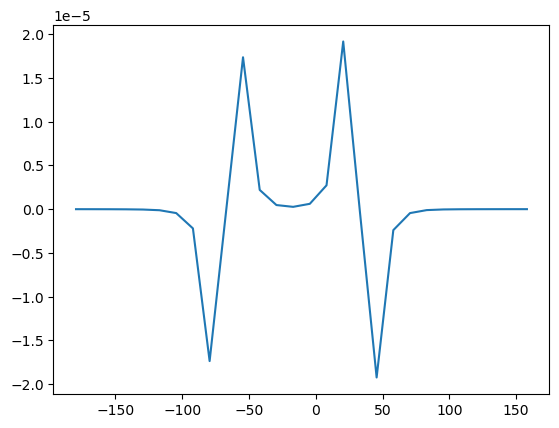

In [8]:
## Add uncertainty
std = 0.01 * torch.abs(data) + 1e-6
data_noisy = data + torch.randn(data.shape, dtype=data.dtype) * std
import matplotlib.pyplot as plt
receivers_positions = rx.locations_m.numpy()[:, 0]
plt.plot(receivers_positions, data.detach().numpy())


In [17]:
## Run inversion

from simpegtorch.inversion import (
    BaseInversion,
    BaseInvProblem,
    BetaSchedule,
    TargetMisfit,
    BetaEstimate_ByEig,
)
from simpegtorch.data_misfit import L2DataMisfit
from simpegtorch.regularization import WeightedLeastSquares

# Create a simple dipole-dipole survey based on actual mesh extent
base_sigma = 1e-3
base_map = mappings.BaseMapping(torch.ones(mesh.nC) * base_sigma)
pde_trainable = DC2DCellCentered(
    mesh,
    survey_torch,
    base_map,
    nky=11
)

solver_trainable =  DirectSolver(pde_trainable)
misfit = L2DataMisfit(solver_trainable, data_noisy, 1/std)
reg_small = WeightedLeastSquares(
    mesh,
    mapping=base_map,
    alpha_s=0.1,
    alpha_x=1.0,
    alpha_y=1.0,
)

optimizer = torch.optim.LBFGS(
    [base_map.trainable_parameters],
    max_iter=20,
    lr=1.0,
    line_search_fn="strong_wolfe",
)


inv_prob = BaseInvProblem(
    misfit, reg_small, optimizer, beta=1.0, max_iter=100
)

directives = [
    BetaEstimate_ByEig(),
    BetaSchedule(cooling_factor=1.2, cooling_rate=1.0),
    #TargetMisfit(chi_factor=1.0),
]

inversion = BaseInversion(inv_prob, directives)

# Run inversion
sigma_recovered = inversion.run()

BetaEstimate: β set to 2.04e+03 (ratio = 1.0)
Running inversion with 2 directives
Device: cpu, dtype: torch.float64
Iter   0: φ = 7.30e+01 (φ_d = 3.65e+01, β×φ_m = 3.65e+01) 
BetaSchedule: β reduced from 2.04e+03 to 1.70e+03
Iter   1: φ = 6.57e+01 (φ_d = 3.53e+01, β×φ_m = 3.04e+01) 
BetaSchedule: β reduced from 1.70e+03 to 1.41e+03
Iter   2: φ = 6.05e+01 (φ_d = 3.52e+01, β×φ_m = 2.53e+01) 
BetaSchedule: β reduced from 1.41e+03 to 1.18e+03
Iter   3: φ = 5.62e+01 (φ_d = 3.51e+01, β×φ_m = 2.11e+01) 
BetaSchedule: β reduced from 1.18e+03 to 9.82e+02
Iter   4: φ = 5.25e+01 (φ_d = 3.49e+01, β×φ_m = 1.76e+01) 
BetaSchedule: β reduced from 9.82e+02 to 8.19e+02
Iter   5: φ = 4.94e+01 (φ_d = 3.48e+01, β×φ_m = 1.46e+01) 
BetaSchedule: β reduced from 8.19e+02 to 6.82e+02
Iter   6: φ = 4.13e+01 (φ_d = 2.93e+01, β×φ_m = 1.19e+01) 
BetaSchedule: β reduced from 6.82e+02 to 5.68e+02
Iter   7: φ = 3.90e+01 (φ_d = 2.91e+01, β×φ_m = 9.93e+00) 
BetaSchedule: β reduced from 5.68e+02 to 4.74e+02
Iter   8: φ 

<Axes: >

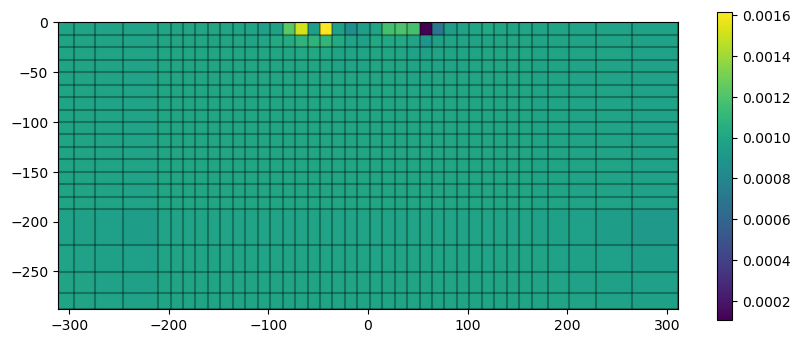

In [18]:
## Plot the recovered model
fig, ax = plt.subplots(figsize=(10, 4))
mesh.plot_grid(ax=ax, alpha=0.3)
mesh.plot_image(
    sigma_recovered.forward().detach(),
    ax=ax,
    pcolor_opts={"cmap": "viridis"},
)